# [ADA-2020]: P4-milestone
### Group project: Friendship and home position

**Objective**: Inspect the difference in quantity, quality and distribution of friends according to where a person lives

**Authors**: ADA Dream Team

**Study paper**: Eunjoon Cho, Seth A. Myers and Jure Leskovec, *Friendship and Mobility: User Movement in Location-Based Social Network*, Standford University, 2011

**Datasets**:
1. Gowalla dataset: https://snap.stanford.edu/data/loc-gowalla.html. A dataset from the paper. Checkins of users and friends relationship.
2. Brightkite dataset: https://snap.stanford.edu/data/loc-Brightkite.html. A dataset from the paper. Checkins of users and friends relationship.
3. Compilation of UNData: https://www.kaggle.com/sudalairajkumar/undata-country-profiles. Different characteristics for each country.
4. Compilation of USGovt: https://www.kaggle.com/fernandol/countries-of-the-world. More characteristics for each country.
5. happiness2020.pkl and countries_info.csv from "tutorial 01- Handling data", extracted from the World Happiness Report of the United Nations Sustainable Development Solution Network. More characteristics for each country.

**Method**: The method that will be used here is the following:

<span style="color:red">!! ADD WHOLE METHOD (SUMMARY)!!</span>

**Others**: 
The abstract as well as the research questions can be found on the README.md.

In [1]:
#Librairies

#General purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

#Convert country names to ISO codes
import pycountry 
import pycountry_convert 

#Convert longitudes and latitudes to country
import reverse_geocoder 

#Plot country map
import cartopy 
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely.wkt as wkt
from shapely.geometry import MultiPolygon

#Handle colors
import matplotlib.cm as cm
import matplotlib.colors as mcolors

#Library to normalize/standarize values
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

#Statistical tests
from bioinfokit.analys import stat
from scipy import stats

#ML mehtods
from sklearn.mixture import GaussianMixture # clustering
import statsmodels.formula.api as smf       # regression
from pca import pca                         # principal component analysis

In [2]:
#Global constants
PATH = "data/"

## 0. Extraction of the data, preprocessing and merge
In this section, the different dataset will be loaded and preprocessed. Preprocess is the same as the one presented in the tutorial and in our previous milestone. The countries dataset will be merged together to form a big dataset with all the data about each country.

### 0.1 Users dataset
Gowalla and Brightkite are social networks. Their dataset are composed of checkins of each users (place, date, ...) and their friendship relations.

In [3]:
#Extraction parameters
EXTENSION = ".txt.gz"
SEPARATOR = "\t"
CHECKIN_COLUMNS_NAME = ["user", "check-in time", "latitude", "longitude", "location id"]
EDGE_COLUMNS_NAME = ["friend1", "friend2"]
#Extract dataframe from .txt.gz (tabulated separated without header)
user = "IDS"
if user == "ANDRES":
    gowalla_edges = pd.read_csv(PATH+"Gowalla_edges.csv", sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    gowalla_checkins = pd.read_csv(PATH+"Gowalla_totalCheckins.csv", sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
    bright_edges = pd.read_csv(PATH+"Brightkite_edges.csv", sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    bright_checkins = pd.read_csv(PATH+"Brightkite_totalCheckins.csv", sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
elif user == "IDS":
    bright_edges = pd.read_csv(PATH+"loc-brightkite_edges"+EXTENSION, sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    bright_checkins = pd.read_csv(PATH+"loc-brightkite_totalCheckins"+EXTENSION, sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
    gowalla_edges = pd.read_csv(PATH+"loc-gowalla_edges"+EXTENSION, sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    gowalla_checkins = pd.read_csv(PATH+"loc-gowalla_totalCheckins"+EXTENSION, sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
else:
    bright_edges = pd.read_csv(PATH+"loc-brightkite_edges"+EXTENSION, sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    bright_checkins = pd.read_csv(PATH+"loc-brightkite_totalCheckins"+EXTENSION, sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
    gowalla_edges = pd.read_csv(PATH+"loc-gowalla_edges"+EXTENSION, sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    gowalla_checkins = pd.read_csv(PATH+"loc-gowalla_totalCheckins"+EXTENSION, sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)


#Remove from checkin some invalid points (null data and incoherent latitudes)
bright_0_lat = bright_checkins[bright_checkins["latitude"] == 0]
bright_0_lat_long = bright_0_lat[bright_0_lat["longitude"] == 0]
bright_checkins = bright_checkins.drop(bright_0_lat_long.index)
bright_big_lat = bright_checkins[bright_checkins["latitude"]>90]
bright_checkins = bright_checkins.drop(bright_big_lat.index)
bright_small_lat = bright_checkins[bright_checkins["latitude"]<-90]
bright_checkins = bright_checkins.drop(bright_small_lat.index)

gowalla_0_lat = gowalla_checkins[gowalla_checkins["latitude"] == 0]
gowalla_0_lat_long = gowalla_0_lat[gowalla_0_lat["longitude"] == 0]
gowalla_checkins = gowalla_checkins.drop(gowalla_0_lat_long.index)
gowalla_big_lat = gowalla_checkins[gowalla_checkins["latitude"]>90]
gowalla_checkins = gowalla_checkins.drop(gowalla_big_lat.index)
gowalla_small_lat = gowalla_checkins[gowalla_checkins["latitude"]<-90]
gowalla_checkins = gowalla_checkins.drop(bright_small_lat.index)

#Sample dataframe to analyze and verify structure
#bright_edges.sample(1)
bright_checkins.sample(1)
#gowalla_edges.sample(1)
#gowalla_checkins.sample(1)

,user,check-in time,latitude,longitude,location id
1144250,3179,2009-01-31T22:11:43Z,56.0,-3.883333,d15695eca22411ddb027d73f398c8667


We merge BrightKite and Gowalla datasets (but users of one cannot be friend with users of the other).

In [4]:
#Find max ids for brightkite
max_b_checkin_id = bright_checkins.index.max()
max_b_user_id =  bright_checkins.user.max()

#Increment Gowalla ids by max of BrightKite
gowalla_checkins.index = gowalla_checkins.index + (max_b_checkin_id+1)
gowalla_checkins.user = gowalla_checkins.user + (max_b_user_id+1)
gowalla_edges.friend1 = gowalla_edges.friend1 + (max_b_user_id+1)
gowalla_edges.friend2 = gowalla_edges.friend1 + (max_b_user_id+1)

#Concatenate the datasets
checkins = bright_checkins.append(gowalla_checkins)
edges = bright_edges.append(gowalla_edges)

### 0.2 Countries dataset
Three different dataset with informations about countries will be used. The first one is from the World Happiness Report of the United Nations Sustainable Development Solution Network, it was presented in the Tutorial of this class; it will be refered as country_WHR (for World Happiness Report). The second one is a compilation (from https://www.kaggle.com/sudalairajkumar/undata-country-profiles) of data from the UN (http://data.un.org/); it will refered as country_UN. The last one is also a compilation (https://www.kaggle.com/fernandol/countries-of-the-world) of data from the CIA (https://www.cia.gov/library/publications/the-world-factbook/); it will be refered as country_CIA.

First, we load and preprocess each one. Then we merge all their information into a big dataset; countries_features.

#### 0.2.1  World Happiness Report (WHR)

In [5]:
#Load data
countries = pd.read_csv(PATH+"countries_info.csv")
happiness = pd.read_pickle(PATH+"happiness2020.pkl")

#Lower case countries from happiness so merge will be possible
happiness["country"] = happiness["country"].str.lower()
#Change column name so they will merge (not duplicated) #!may exist a simpler alternative in the merge options
names = countries.columns.tolist()
names[names.index("country_name")] = "country"
countries.columns = names
#Merge
country_WHR = pd.merge(happiness, countries, left_on = "country", right_on = "country")

#Drop the columns if there is an invalid data (we won't be able to use feature if not all country have it)
country_WHR = country_WHR.dropna(axis = 1)

#Restore first letter as upper case for latter use
country_WHR.country = country_WHR.country.str.title()

#Sample dataframe to analyze and verify structure
country_WHR.sample(1)

,country,happiness_score,social_support,healthy_life_expectancy,freedom_of_choices,generosity,perception_of_corruption,world_region,area,population
55,Ireland,7.0937,0.942082,72.300789,0.886983,0.145785,0.357184,Western Europe,70280,4062235


#### 0.2.2  United Nation Compilation (UN)

In [6]:
#Converts the ratio string ("x/y") to the corresponding float
def string_div_to_float(my_string):
    try:
        num, denom = my_string.split('/')
        return float(num) / float(denom)
    except ValueError: #some of the data have ".../..." as a ratio...
        return -100

In [7]:
#Load data (Some datasets represents ratio as such strings "x/y", we will convert it with a float resulting of the division)
country_UN = pd.read_csv(PATH+"country_profile_variables.csv", converters={"Labour force participation (female/male pop. %)":string_div_to_float, "Life expectancy at birth (females/males, years)":string_div_to_float,"Education: Primary gross enrol. ratio (f/m per 100 pop.)":string_div_to_float, "Education: Tertiary gross enrol. ratio (f/m per 100 pop.)":string_div_to_float,"Population age distribution (0-14 / 60+ years, %)":string_div_to_float, "Forested area (% of land area)":string_div_to_float,"Education: Secondary gross enrol. ratio (f/m per 100 pop.)":string_div_to_float,"International migrant stock (000/% of total pop.)":string_div_to_float,"Energy supply per capita (Gigajoules)":string_div_to_float,"Pop. using improved drinking water (urban/rural, %)":string_div_to_float})

#Treat some aberrations
country_UN = country_UN.replace("~0.0",0)
country_UN = country_UN.replace("...",np.nan)

#Drop the columns if there is an invalid data (we won't be able to use feature if not all country have it)
country_UN = country_UN.dropna(axis = 1)

#Remove Guadeloupe and Mayotte that are french
country_UN = country_UN[country_UN.country != "Guadeloupe"]
country_UN = country_UN[country_UN.country != "Mayotte"]

#Sample dataframe to analyze and verify structure
country_UN.sample(1)

,country,Region,Surface area (km2),Population in thousands (2017),"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)",GDP: Gross domestic product (million current US$),"GDP growth rate (annual %, const. 2005 prices)",GDP per capita (current US$),Economy: Agriculture (% of GVA),...,Education: Tertiary gross enrol. ratio (f/m per 100 pop.),Seats held by women in national parliaments %,Individuals using the Internet (per 100 inhabitants),Threatened species (number),Forested area (% of land area),CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)",Energy supply per capita (Gigajoules),"Pop. using improved drinking water (urban/rural, %)",Net Official Development Assist. received (% of GNI)
96,Indonesia,South-easternAsia,1910931,263991,145.7,101.4,861934,4.8,3346.5,14.0,...,1.122271,19.8,1281,50.6,257.888889,19481,35,1.184906,1.522105,-99


#### 0.2.3  Central Intelligence Agency Compilation (CIA)

In [8]:
#Load data
country_CIA = pd.read_csv(PATH+"countries of the world.csv")

#Same country index name
country_CIA = country_CIA.rename(columns = {"Country":"country"})

#Change commas with dot
country_CIA = country_CIA.stack().str.replace(',','.').unstack()

#Remove Guadeloupe and Mayotte that are french and Virgin Islands that are american
country_CIA = country_CIA[country_CIA.country != "Guadeloupe "]
country_CIA = country_CIA[country_CIA.country != "Mayotte "]
country_CIA = country_CIA[country_CIA.country != "Virgin Islands "]

#Drop the columns if there is an invalid data (we won't be able to use feature if not all country have it)
country_CIA = country_CIA.dropna(axis = 1)

#Sample dataframe to analyze and verify structure
country_CIA.sample(1)

,country,Region,Pop. Density (per sq. mi.),Coastline (coast/area ratio)
44,Comoros,SUB-SAHARAN AFRICA,318.4,15.67


#### 0.2.4 Merge the three datasets
The three datasets will be merged in this section. To be able to merge them we need a common identifier, to do so we use the pycountry library. We did not found a library able to work with pandas so we have to do a lambda iteration, which is reasonable as the number of countries is not incredeibly large and we only do it once. 

Note that the WHR dataset is smaller than the two others. Also note that during this conversion some countries are not correctly identified and so are removed, however these countries are in most cases small islands or countries in development which may have very little nor no data for the networks dataset.

In [9]:
#from https://codereview.stackexchange.com/questions/238714/basic-function-to-convert-country-name-to-iso-code-using-pycountry
# convert country name in alpha 3 name
def country_to_alpha3(country):
    try:
        result = pycountry.countries.search_fuzzy(country)
    except Exception:
        return np.nan
    else:
        return result[0].alpha_3

#Convert the name of a country to alpha 2 code
def country_to_alpha2(country):
    try:
        result = pycountry_convert.country_name_to_country_alpha2(country)
    except Exception:
        result = np.nan
    return result

In [10]:
#Create a table to convert country - alpha 3 and alpha 2 : ALPHA3 will be used as much as possible
countries_names = country_UN.country.unique()
countries_alpha2 = np.array([country_to_alpha2(country) for country in countries_names])
countries_alpha3 = np.array([country_to_alpha3(country) for country in countries_names])

#Group them
country_translator = pd.DataFrame(data = {"country":countries_names,"alpha2":countries_alpha2,"alpha3":countries_alpha3})

#Send Nigeria and Niger to invalid country because they have the same alpha3 (same for worst and best Korea)
country_translator = country_translator[country_translator.alpha3 != "PRK"]
country_translator = country_translator[country_translator.alpha3 != "NGA"]

#Drop a country if it has no code associated
country_translator = country_translator.replace("nan",np.nan).dropna()

#Example
country_translator.sample(1)

,country,alpha2,alpha3
154,Papua New Guinea,PG,PNG


In [11]:
#Create a function that given an array of alpha2 returns an array of alpha3
def alpha2_to_alpha3(alpha2s):
    df = pd.DataFrame({"alpha2" : alpha2s})
    #Merge the dataset
    res = df.merge(country_translator, left_on = "alpha2", right_on = "alpha2", how="left")
    #Remove the added columns
    return res["alpha3"].astype("string")

In [12]:
#Change country names to alpha3 so they can be compared  (we cannot use the table because names maybe differents)
country_WHR['alpha3'] = country_WHR.country.apply(lambda name: country_to_alpha3(name))
country_UN['alpha3'] = country_UN.country.apply(lambda name: country_to_alpha3(name))
country_CIA['alpha3'] = country_CIA.country.apply(lambda name: country_to_alpha3(name))

#Remove the countries that received invalid alpha3 number
country_WHR = country_WHR.dropna()
country_UN = country_UN.dropna()
country_CIA = country_CIA.dropna()
#Nigeria and Niger have the same alpha3 code
country_WHR = country_WHR[country_WHR.alpha3 != "NGA"] 
country_UN = country_UN[country_UN.alpha3 != "NGA"]
country_CIA = country_CIA[country_CIA.alpha3 != "NGA"]
#Same for best and worst Korea
country_WHR = country_WHR[country_WHR.alpha3 != "PRK"] 
country_UN = country_UN[country_UN.alpha3 != "PRK"]
country_CIA = country_CIA[country_CIA.alpha3 != "PRK"]
#Remove the information repeated accross datasets
TO_REMOVE_WHR = ["healthy_life_expectancy", "world_region", "area", "population","country"]
TO_REMOVE_CIA = ["Region","country","Pop. Density (per sq. mi.)"]
TO_REMOVE_UN = ["country"]
country_WHR = country_WHR.drop(columns = TO_REMOVE_WHR)
country_CIA = country_CIA.drop(columns = TO_REMOVE_CIA)
country_UN = country_UN.drop(columns = TO_REMOVE_UN)

In [13]:
#Merge the different datasets
countries_features = country_WHR.merge(country_UN, left_on = "alpha3", right_on = "alpha3", how="inner")
countries_features = countries_features.merge(country_CIA, left_on = "alpha3", right_on = "alpha3", how="inner")

countries_features.rename(columns = {
 'Population density (per km2, 2017)' : "Population_density",
 'Sex ratio (m per 100 f, 2017)' : 'Sex_ratio',
 'GDP growth rate (annual %, const. 2005 prices)' : 'GPD_growth_rate',
 'GDP per capita (current US$)' : 'GDP_per_capita',
 'Labour force participation (female/male pop. %)': 'Labour_force_participation',
 'Population growth rate (average annual %)' : 'Population_growth_rate',
 'Urban population (% of total population)' : 'Urban_population',
 'Urban population growth rate (average annual %)' : 'Urban_population_growth_rate',
 'Life expectancy at birth (females/males, years)' : 'Life_expectancy_at_birth',
 'Population age distribution (0-14 / 60+ years, %)' : 'Population_age_distribution',
 'International migrant stock (000/% of total pop.)' : 'International_migrant_stock',
 'Health: Total expenditure (% of GDP)' : 'Heath_total_expenditure',
 'Education: Primary gross enrol. ratio (f/m per 100 pop.)' : 'Education_Primary',
 'Education: Secondary gross enrol. ratio (f/m per 100 pop.)' : 'Education_Secondary',
 'Education: Tertiary gross enrol. ratio (f/m per 100 pop.)' : 'Education_Tertiary',
 'Individuals using the Internet (per 100 inhabitants)' : 'Individuals_using_the_Internet',
 'Forested area (% of land area)' : 'Forested_area',
 'Energy supply per capita (Gigajoules)' : 'Energy_supply_per_capita',
 'Coastline (coast/area ratio)' : 'Coastline'}, inplace = True)

#Sample dataframe to analyze and verify structure
countries_features.sample(4)

,happiness_score,social_support,freedom_of_choices,generosity,perception_of_corruption,alpha3,Region,Surface area (km2),Population in thousands (2017),Population_density,...,Seats held by women in national parliaments %,Individuals_using_the_Internet,Threatened species (number),Forested_area,CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)",Energy_supply_per_capita,"Pop. using improved drinking water (urban/rural, %)",Net Official Development Assist. received (% of GNI),Coastline
6,7.2942,0.928046,0.899989,0.085429,0.499955,AUT,WesternEurope,83871,8736,106.0,...,30.6,118,46.9,8.507246,505,158,1.000000,1.000000,-99,0.00
87,5.6933,0.689062,0.734834,0.044900,0.745705,PAK,SouthernAsia,796095,197016,255.6,...,20.6,140,2.0,184.777778,2202,17,1.044494,1.626223,-99,0.13
16,4.7687,0.712944,0.665564,-0.019081,0.739795,BFA,WesternAfrica,272967,19193,70.2,...,11.0,31,19.8,28.000000,123,9,1.286280,7.522388,-99,0.00
60,4.5830,0.702652,0.829748,0.294682,0.831499,KEN,EasternAfrica,591958,49700,87.3,...,19.4,480,7.7,47.666667,750,20,1.436620,1.050505,-99,0.09


From all the features we remove the ones that we consider uninteresting for our application or repeated in different ways (density of population and total population).

In [14]:
TO_REMOVE = ["Surface area (km2)","GDP: Gross domestic product (million current US$)", "Economy: Agriculture (% of GVA)","Economy: Industry (% of GVA)", "Economy: Services and other activity (% of GVA)","Agricultural production index (2004-2006=100)","Food production index (2004-2006=100)","Seats held by women in national parliaments %","Threatened species (number)","CO2 emission estimates (million tons/tons per capita)","Energy production, primary (Petajoules)","Pop. using improved drinking water (urban/rural, %)","Net Official Development Assist. received (% of GNI)"]
countries_features = countries_features.drop(columns=TO_REMOVE)

In the end, we have a dataset with 127 countries (there was 131 valid countries in the WHR dataset). In total there is 26 columns. So there is 25 features for each country, they are:

In [15]:
features_global = countries_features.columns
for feature in features_global:
    if(feature != "country" and feature != "alpha3_name"):
        print(feature)

happiness_score
social_support
freedom_of_choices
generosity
perception_of_corruption
alpha3
Region
Population in thousands (2017)
Population_density
Sex_ratio
GPD_growth_rate
GDP_per_capita
Labour_force_participation
Population_growth_rate
Urban_population
Urban_population_growth_rate
Life_expectancy_at_birth
Population_age_distribution
International_migrant_stock
Heath_total_expenditure
Education_Primary
Education_Secondary
Education_Tertiary
Individuals_using_the_Internet
Forested_area
Energy_supply_per_capita
Coastline


The country in our dataset are represented above (code copied by https://github.com/SciTools/cartopy/issues/1303 and exception error by https://stackoverflow.com/questions/63943614/python-cartopy-how-to-solve-polygon-object-error):

In [16]:
#Color a counter (indicated by its ISO code) in a color
def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, 
                                  alpha = 1.00, linewidth =0.15, edgecolor = "black",
                                  label=n.attributes['ADM0_A3']) 
            except Exception as e:
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr, 
                                  alpha = 1.00, linewidth =0.15, edgecolor = "black",
                                  label=n.attributes['ADM0_A3']) 
            return ax

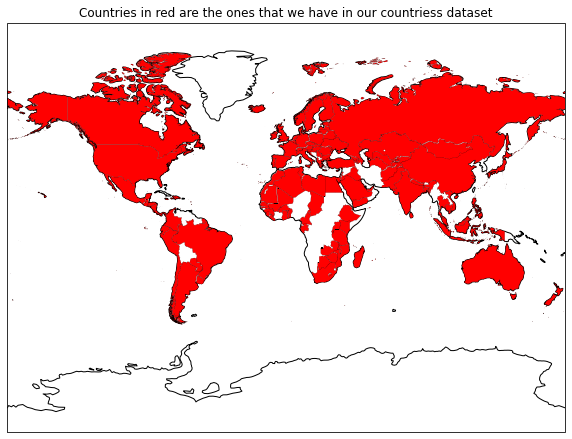

In [17]:
#Plot the countries that are in our dataset (!takes some time)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

for n in countries_features.alpha3 :
    area(ax, n, "red")
    
plt.title("Countries in red are the ones that we have in our countriess dataset")
plt.show()

## 1. Compute home position
Average the home position of the users. This is done like explained in the paper. The implementation is exactly the same as what was done for P2-milestone and so here we just load the result. The jupyter notebook that explain this can be found in the git under the name "replication_report".

In [18]:
#Load the home position
bright_home_pos_light = pd.read_csv(PATH+"b_home.csv").set_index("user")
gowalla_home_pos_light = pd.read_csv(PATH+"g_home.csv").set_index("user")

#Merge the two homes datasaets
gowalla_home_pos_light.index = gowalla_home_pos_light.index + (max_b_user_id+1)
home_pos = bright_home_pos_light.append(gowalla_home_pos_light)

In [19]:
#Sample dataframe to analyze and verify structure
home_pos.sample(4)

,lat,long
user,,
44257,60.666667,17.166667
214411,49.456359,11.085209
236727,52.520196,13.395199
19760,43.324456,-79.796058


## 2. Compute nationality and remove non used countries

### 2.1 Compute nationality of the users
Convert longitude latitude to country. To do so we use the reverse_geocoder library.

In [20]:
#Convert long-lat peer in tupple so it is easier for the library
longlat_tupple = list(zip(home_pos.lat, home_pos.long))

#Search the localisation of each datapoint
home_pos_tmp = home_pos.copy()
home_pos_tmp["loc"] = reverse_geocoder.search(longlat_tupple)

#Separate the localisation information in the different part (name of the city, admin district, country code)
home_pos_tmp = pd.DataFrame(home_pos_tmp['loc'].tolist(), index=home_pos_tmp.index)

#Convert country code to country name
home_pos_tmp["alpha3"] = alpha2_to_alpha3(home_pos_tmp.cc)

#Remove if a country is not represented by an alpha3 value
home_pos_tmp = home_pos_tmp.dropna()

#Remove the useless columns
TO_REMOVE = ["name","admin1","admin2","cc","lat","lon"]
nat = home_pos_tmp.drop(columns = TO_REMOVE)

#An other dataset with also the position of the home
TO_REMOVE = ["name","admin1","admin2","cc"]
home_pos = home_pos_tmp.drop(columns = TO_REMOVE)



#Sample dataframe to analyze and verify structure
#nat.sample(4)
home_pos.sample(4)

Loading formatted geocoded file...


,lat,lon,alpha3
user,,,
41186,-33.88965,151.17642,USA
99369,45.50884,-73.58781,USA
19402,21.30694,-157.85833,USA
1524,33.41421,-111.94348,USA


### 2.2 Find less used countries and remove them
To decide whatever we keep or not a country we compute its users density (sum of the two applications). 

The minimum density is set to 1 person over 100'000 in one country that have th application. It may seem very few, however the dataset has very low density for all countries (see plot and description above, only green are availible with our density) and we need to have at least some countries to compare.

<span style="color:red">DISCUSS THIS CHOICE</span> 

In [21]:
#Count the users of each country
countries_count = nat.alpha3.value_counts()

In [22]:
#Do a safety guard
countries_features_temp = countries_features

#Add the number of users to the countries features and remove
countries_features_temp = countries_features_temp.merge(countries_count, left_on = "alpha3", right_index = True, how = "left")
countries_features_temp = countries_features_temp.rename(columns = {"alpha3_x":"alpha3"})
countries_features_temp = countries_features_temp.rename(columns = {"alpha3_y":"users"})
#Replace the NaN values to 0
countries_features_temp = countries_features_temp.fillna(0)

#Compute the density of users in the population
countries_features_temp["density_users"] = countries_features_temp["users"]/(countries_features_temp["Population in thousands (2017)"]*1000)

In [23]:
countries_features_temp

,happiness_score,social_support,freedom_of_choices,generosity,perception_of_corruption,alpha3,Region,Population in thousands (2017),Population_density,Sex_ratio,...,Heath_total_expenditure,Education_Primary,Education_Secondary,Education_Tertiary,Individuals_using_the_Internet,Forested_area,Energy_supply_per_capita,Coastline,users,density_users
0,2.5669,0.470367,0.396573,-0.096429,0.933687,AFG,SouthernAsia,35530,54.4,106.3,...,8.2,0.692249,0.561528,0.278195,42,32.666667,1.663830,0.00,2,5.629046e-08
1,4.8827,0.671070,0.781994,-0.042309,0.896304,ALB,SouthernEurope,2930,106.9,101.9,...,5.9,0.967100,0.936235,1.398357,130,2.850000,0.996849,1.26,0,0.000000e+00
2,5.0051,0.803385,0.466611,-0.121105,0.735485,DZA,NorthernAfrica,41318,17.3,102.0,...,7.2,0.943096,1.036697,1.560554,135,39.297297,1.030562,0.04,8,1.936202e-07
3,5.9747,0.900568,0.831132,-0.194914,0.842010,ARG,SouthAmerica,44271,16.2,95.9,...,4.8,0.996370,1.066731,1.620472,256,43.404255,0.990000,0.18,88,1.987757e-06
4,4.6768,0.757479,0.712018,-0.138780,0.773545,ARM,WesternAsia,2930,102.9,88.8,...,4.5,1.000000,1.010216,1.127404,114,3.055556,1.000000,0.00,0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,6.2576,0.926596,0.974998,0.248427,0.501497,UZB,CentralAsia,31911,75.0,99.4,...,5.8,0.977273,0.982438,0.645455,59,29.222222,1.217553,0.00,3,9.401147e-08
123,5.3535,0.849987,0.939593,-0.094533,0.796421,VNM,South-easternAsia,95541,308.1,98.0,...,7.1,0.991766,-100.000000,1.003472,616,92.722222,1.022704,1.05,83,8.687370e-07
124,3.5274,0.817981,0.599920,-0.157735,0.800288,YEM,WesternAsia,28250,53.5,102.1,...,5.6,0.841060,0.688153,0.445255,298,25.222222,1.548387,0.36,0,0.000000e+00
125,3.7594,0.698824,0.806500,0.078037,0.801290,ZMB,EasternAfrica,17094,23.0,98.5,...,5.0,1.006776,-100.000000,0.755556,88,15.000000,1.668616,0.00,3,1.755002e-07


count      127.000000
mean       825.031496
std       5278.609428
min          0.000000
25%          2.000000
50%         14.000000
75%        180.000000
max      58384.000000
Name: users, dtype: float64


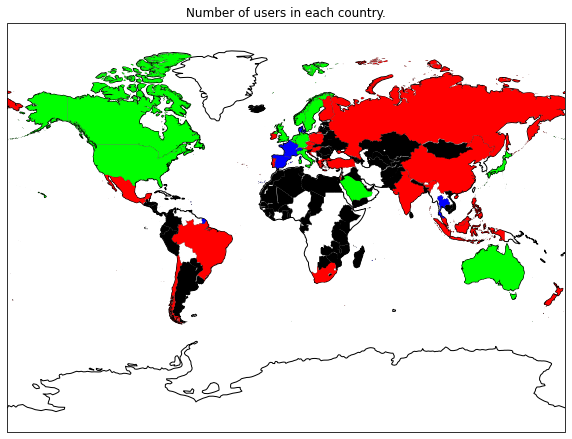

In [24]:
# Plot the number of users distribution
temp = countries_features_temp.copy()

#Plot the countries that are in our dataset (!takes some time)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

for index, t in temp.iterrows() :
    color = (0,0,0)
    if(t.users > 1000):
        color = (0,1,0)
    elif(t.users > 500):
        color = (0,0,1)
    elif(t.users > 100):
        color = (1,0,0)
    area(ax, t.alpha3, color)
    
plt.title("Number of users in each country.")
print(temp.users.describe())

In [25]:
#Remove the countries that have less than 100 users (incoherent results even if enough density)
countries_features_temp = countries_features_temp[countries_features_temp.users > 100]

count    4.100000e+01
mean     7.556355e-05
std      1.712459e-04
min      2.120701e-07
25%      9.929168e-06
50%      2.482693e-05
75%      7.676987e-05
max      1.009989e-03
Name: density_users, dtype: float64


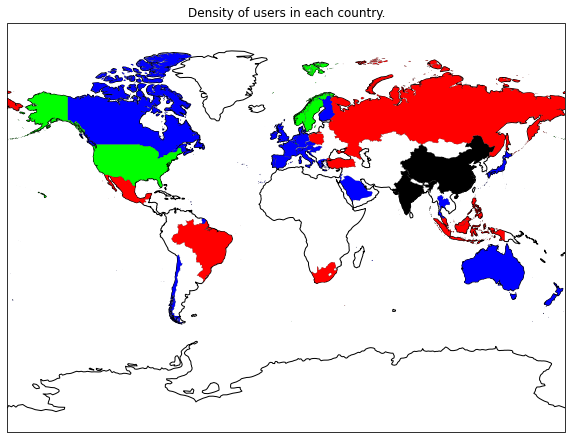

In [26]:
# Plot the density distribution (add Alpha 3 just for the plot)
temp = countries_features_temp.copy()

#Plot the countries that are in our dataset (!takes some time)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

for index, t in temp.iterrows() :
    color = (0,0,0)
    if(t.density_users > 1e-4):
        color = (0,1,0)
    elif(t.density_users > 1e-5):
        color = (0,0,1)
    elif(t.density_users > 1e-6):
        color = (1,0,0)
    area(ax, t.alpha3, color)
    
plt.title("Density of users in each country.")
print(temp.density_users.describe())

In [27]:
#Parameter
MIN_DENSITY = 1e-5

#keep only the countries that have a minimum density of users
countries_features_clean = countries_features_temp[countries_features_temp["density_users"] > MIN_DENSITY]
valid_countries_alpha3 = countries_features_clean.alpha3.values

#Remove the useless columns
TO_REMOVE = ["users","density_users","Population in thousands (2017)"]
countries_features_clean = countries_features_clean.drop(columns = TO_REMOVE)

#Sample dataframe to analyze and verify structure
countries_features_clean.sample(4)

,happiness_score,social_support,freedom_of_choices,generosity,perception_of_corruption,alpha3,Region,Population_density,Sex_ratio,GPD_growth_rate,...,Population_age_distribution,International_migrant_stock,Heath_total_expenditure,Education_Primary,Education_Secondary,Education_Tertiary,Individuals_using_the_Internet,Forested_area,Energy_supply_per_capita,Coastline
120,6.9396,0.914219,0.842620,0.149892,0.699715,USA,NorthernAmerica,35.5,98.0,2.6,...,0.879070,3215.662069,17.1,0.997009,1.018614,1.368132,1513,324.339506,1.01222,0.21
93,5.9109,0.886591,0.888748,-0.220714,0.892630,PRT,SouthernEurope,112.8,89.8,1.6,...,0.487455,103.370370,9.5,0.962523,0.969421,1.132759,281,10.488372,1.00000,1.94
38,6.6638,0.937104,0.825468,-0.130642,0.583521,FRA,WesternEurope,118.7,96.7,1.3,...,0.704280,643.338843,11.5,0.993377,1.009991,1.226252,278,64.531915,1.00000,0.63
29,6.9109,0.914431,0.818537,-0.230862,0.858446,CZE,EasternEurope,137.5,96.7,4.5,...,0.601562,106.605263,7.4,1.003012,1.009515,1.407749,53,10.489130,1.00000,0.00


In [28]:
#Create a min max version of the dataset (useful for plots)
scaler = MinMaxScaler()
countries_features_0_1 = countries_features_clean.copy()

for column in countries_features_0_1.columns:
    if column != "alpha3" and column != "Region":
        countries_features_0_1[column] = scaler.fit_transform((countries_features_0_1[column].values).reshape(-1,1))


#Create a standarize version of the dataset (useful for ML)
scaler = preprocessing.StandardScaler()
countries_features_std = countries_features_clean.copy()
for column in countries_features_std.columns:
    if column != "alpha3"  and column != "Region":
        countries_features_std[column] = scaler.fit_transform((countries_features_std[column].values).reshape(-1,1))

There are 41 countries availible.


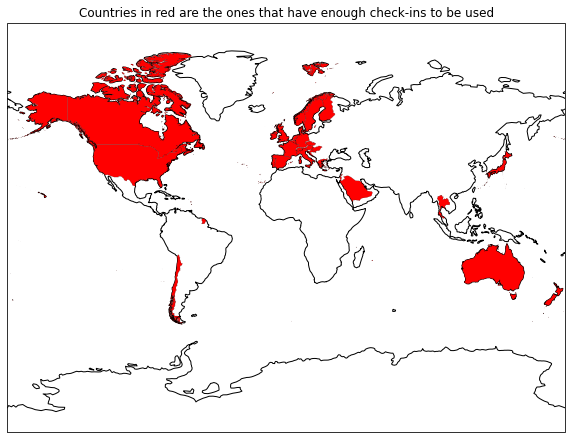

In [29]:
# Plot the countries in the final dataset (add Alpha 3 just for the plot)
temp = countries_features_clean

#Plot the countries that are in our dataset (!takes some time)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

for n in temp.alpha3 :
    area(ax, n, "red")
    
plt.title("Countries in red are the ones that have enough check-ins to be used")
print("There are "+str(countries_features_temp.shape[0])+" countries availible.")
plt.show()

The final number of country is low, but we have to have meaningful results.

### 2.3 Cluster the countries
Try to find if some groups emerge from the countries' features. First data will be normalized (with a StandrardScaler), then we will use k-means with a set of k-values to find the optimal number of clusters. Finally, we show the emerging clusters.

In [30]:
#Generate a list of colors for the plots
colors = mcolors.BASE_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name) for name, color in colors.items())
color_names = [name for hsv, name in by_hsv]
color_names.remove("w") #pop white
color_names.extend(["gray","brown","orange","lightgreen","cyan","beige","pink","navy","tan","lime","royalblue","brown","moccasin","deeppink","magenta","slategrey","dodgerblue","oldlace"])
NB_MAX_GRP = len(color_names)

In [31]:
#Save the indetificators that we need
countires_codes = countries_features_std.alpha3

#Remove the information that can not be used for clustering
TO_REMOVE = ["alpha3","Region"]
country_clustering = countries_features_std.drop(columns=TO_REMOVE)

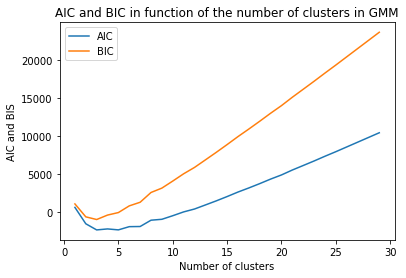

In [32]:
#Initialize the variables
all_aic = []
all_bic = []
NB_MAX_CENTROIDS = len(countires_codes)

#Evaluate the root mean square (RMS) with different values of k
for nb_centroids in range(1, NB_MAX_CENTROIDS):
    gmm = GaussianMixture(n_components=nb_centroids, n_init = 50, init_params = "kmeans").fit(country_clustering)
    all_aic.append(gmm.aic(country_clustering))
    all_bic.append(gmm.bic(country_clustering))
    
    
#Plot the result
plt.plot(np.arange(1,NB_MAX_CENTROIDS), all_aic, label = "AIC")
plt.plot(np.arange(1,NB_MAX_CENTROIDS), all_bic, label = "BIC")
plt.title("AIC and BIC in function of the number of clusters in GMM")
plt.xlabel("Number of clusters")
plt.ylabel("AIC and BIS")
plt.legend()

From the plot we see that the minimum for both occurs around 3 clusters.

In [33]:
#Compute with our best resut
BEST_NB_CLUSTERS = 3
gmm = GaussianMixture(n_components=BEST_NB_CLUSTERS, n_init = 100, init_params = "kmeans").fit(country_clustering)
labels = gmm.fit_predict(country_clustering)
res = pd.DataFrame(index = countires_codes, data = labels, columns =["labels"])

In [34]:
#Print the countries in each cluster
for lab in np.unique(labels):
    print("Label n°"+str(lab))
    print(res[res.labels == lab].index.values)

features_clusters = res

Label n°0
['AUT' 'BEL' 'CAN' 'DNK' 'FIN' 'FRA' 'DEU' 'NLD' 'NZL' 'NOR' 'SWE' 'CHE'
 'GBR']
Label n°1
['CHL' 'HRV' 'CZE' 'GRC' 'HUN' 'ITA' 'JPN' 'PRT' 'ESP']
Label n°2
['AUS' 'IRL' 'ISR' 'LUX' 'SAU' 'SGP' 'THA' 'USA']


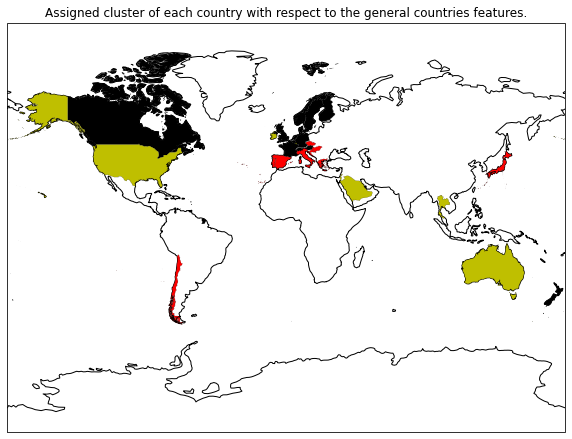

In [35]:
#Create the world for the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

#Extract the clusters
clusters = np.unique(labels)
nb_cluster = np.max(clusters)

#Plot
if(nb_cluster > NB_MAX_GRP): #Some clusters cannot be plotted
    print("COLORS ARE REPEATING")
else:
    for i in range(0, len(labels)) :
        label = labels[i]
        color = color_names[label]
        area(ax, countires_codes.iloc[i], color)

    plt.title("Assigned cluster of each country with respect to the general countries features.")

## 3. Friends charachteristics

### 3.1 Compute Quantitative Charactistics


In [36]:
# Adding to the datasets the nationality of each friend
quant_f = edges.copy()
quant_f = quant_f.merge(nat, left_on="friend1", right_index =True).rename(columns = {"alpha3":"alpha3_1"})
quant_f = quant_f.merge(nat, left_on="friend2", right_index =True).rename(columns = {"alpha3":"alpha3_2"})

#Example
quant_f.sample(4)

,friend1,friend2,alpha3_1,alpha3_2
3349,36,527,USA,USA
375293,33046,6051,USA,GBR
135663,4659,4755,DEU,USA
304813,18689,30656,USA,CAN


In [37]:
quant_f = quant_f.merge(home_pos, left_on="friend1", right_index =True).rename(columns = {"lat":"friend1_lat","lon":"friend1_lon","alpha3":"friend1_alpha3"})
quant_f = quant_f.merge(home_pos, left_on="friend2", right_index =True).rename(columns = {"lat":"friend2_lat","lon":"friend2_lon","alpha3":"friend2_alpha3"})
quant_f.sample(4)

,friend1,friend2,alpha3_1,alpha3_2,friend1_lat,friend1_lon,friend1_alpha3,friend2_lat,friend2_lon,friend2_alpha3
270046,13920,13968,USA,USA,-37.8676,144.98099,USA,37.77493,-122.41942,USA
522674,67275,125503,CAN,THA,41.14149,-73.3579,CAN,30.26715,-97.74306,THA
681280,75761,133989,DNK,BEL,49.19522,16.60796,DNK,41.56283,-83.65382,BEL
382591,63637,121865,AUS,USA,30.26715,-97.74306,AUS,41.80892,-88.01117,USA


In [38]:
#Compute the distance btw the home of the users

# approximate radius of earth in km
R = 6373.0

# Converting grades to radians
quant_f["friend1_lat"] = np.radians(quant_f["friend1_lat"].astype(float))
quant_f["friend2_lat"] = np.radians(quant_f["friend2_lat"].astype(float))
quant_f["friend1_lon"] = np.radians(quant_f["friend1_lon"].astype(float))
quant_f["friend2_lon"] = np.radians(quant_f["friend2_lon"].astype(float))

# Calculating the difference between latitudes and longitudes
quant_f["lat_dis"] = quant_f["friend2_lat"]-quant_f["friend1_lat"]
quant_f["lon_dis"] = quant_f["friend2_lon"]-quant_f["friend1_lon"]

# Haversine method to compute the distance
quant_f["a"] = np.sin(quant_f["lat_dis"] / 2)**2 + np.cos(quant_f["friend1_lat"]) * np.cos(quant_f["friend2_lat"]) * np.sin(quant_f["lon_dis"] / 2)**2
quant_f["c"] = 2 * np.arctan2(np.sqrt(quant_f["a"]), np.sqrt(1 - quant_f["a"]))

quant_f["distance"] = R * quant_f["c"]

In [39]:
threshold = 50 #km between users

# Creating a new data set with friendship info for each user
# Number of friends
friends_ch_q = pd.DataFrame(quant_f.groupby("friend1")["friend2"].count()).rename(columns={"friend2":"n_friends"})
# Number of friends in the same country
friends_ch_q["n_friends_same_country"] = quant_f[quant_f.alpha3_1 == quant_f.alpha3_2].groupby("friend1")["friend2"].count()
# Ratio of friends in the same country
friends_ch_q["ratio_friends_same_country"] = friends_ch_q["n_friends_same_country"]/friends_ch_q["n_friends"]
# Number of friends within a distance
friends_ch_q["n_friends_near"] = quant_f[quant_f.distance < threshold].groupby("friend1")["friend2"].count()
# Ratio of friends within a distance
friends_ch_q["ratio_friends_near"] = friends_ch_q["n_friends_near"]/friends_ch_q["n_friends"]

# Filling Nan values (due to .count() function) with zeros
friends_ch_q = friends_ch_q.fillna(0)

#Example
friends_ch_q.sample(5)

,n_friends,n_friends_same_country,ratio_friends_same_country,n_friends_near,ratio_friends_near
friend1,,,,,
40563,1,1.0,1.000000,0.0,0.0
13985,3,2.0,0.666667,3.0,1.0
41914,1,1.0,1.000000,0.0,0.0
82064,18,18.0,1.000000,0.0,0.0
94609,5,5.0,1.000000,0.0,0.0


### 3.2 Qualitative friendship charachteristics

In [40]:
#drop useless columns and sort dataframe
qual_checkins = checkins.copy()
qual_checkins["check-in time"] = pd.to_datetime(qual_checkins["check-in time"])
qual_times = qual_checkins[["user", "location id", "check-in time"]]
qual_times = qual_times.sort_values(["location id", "check-in time"])

In [41]:
qual_checkins

,user,check-in time,latitude,longitude,location id
0,0,2010-10-17 01:48:53+00:00,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5
1,0,2010-10-16 06:02:04+00:00,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2
2,0,2010-10-16 03:48:54+00:00,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79
3,0,2010-10-14 18:25:51+00:00,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683
4,0,2010-10-14 00:21:47+00:00,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc
...,...,...,...,...,...
11190174,254806,2010-06-11 13:32:26+00:00,51.742988,-0.488065,906885
11190175,254806,2010-06-11 13:26:45+00:00,51.746492,-0.490780,965121
11190176,254806,2010-06-11 13:26:34+00:00,51.741916,-0.496729,1174322
11190177,254813,2010-10-08 21:01:49+00:00,50.105516,8.571525,471724


In [42]:
#time tolerance to define meeting
TOL = 15 #minutes
tol = datetime.timedelta(minutes=TOL)

#compute time differences
qual_times["time_diff_with_prev"] = qual_times["check-in time"].diff()
qual_times["time_diff_with_next"] = qual_times["time_diff_with_prev"].shift(-1)

#drop check-ins isolated by more than TOL -> Reduces dataset 
bool_prev = (qual_times["time_diff_with_prev"] <= tol) & \
            (qual_times["time_diff_with_prev"] >= datetime.timedelta(minutes=0))
bool_next = (qual_times["time_diff_with_next"] <= tol) & \
            (qual_times["time_diff_with_next"] >= datetime.timedelta(minutes=0))

qual_times_small = qual_times[bool_prev | bool_next ]
qual_times_small = qual_times_small.sort_values(["location id", "user"]) 
qual_times_small = qual_times_small.drop(columns = ["time_diff_with_prev", "time_diff_with_next"])

qual_times_small["year"] = qual_times_small["check-in time"].dt.year
qual_times_small["month"] = qual_times_small["check-in time"].dt.month
qual_times_small["day"] = qual_times_small["check-in time"].dt.day

qual_times_small.sample(3)

,user,location id,check-in time,year,month,day
641884,1890,4d865b969afb11de9a9b003048c0801e,2009-09-06 16:39:10+00:00,2009,9,6
10589671,200889,28045,2010-02-26 11:50:58+00:00,2010,2,26
5121563,59502,100206,2010-02-03 21:08:42+00:00,2010,2,3


In [43]:
#build dataframe with check-ins relation
checkins_relation = qual_times_small.merge(qual_times_small, on = ["location id", "year", "month", "day"])

#remove same user relations
checkins_relation =checkins_relation[checkins_relation["user_x"] != checkins_relation["user_y"]]

#compute time difference between users' checkins
checkins_relation["time_diff"] = abs(checkins_relation["check-in time_x"] - checkins_relation["check-in time_y"])

#filter simulateneous check-ins
checkins_relation = checkins_relation[checkins_relation["time_diff"] <= tol]

checkins_relation.head()

,user_x,location id,check-in time_x,year,month,day,user_y,check-in time_y,time_diff
1,58501,8938,2010-04-23 16:57:24+00:00,2010,4,23,58716,2010-04-23 16:58:54+00:00,0 days 00:01:30
2,58716,8938,2010-04-23 16:58:54+00:00,2010,4,23,58501,2010-04-23 16:57:24+00:00,0 days 00:01:30
5,63121,8938,2009-12-14 00:28:35+00:00,2009,12,14,63392,2009-12-14 00:33:38+00:00,0 days 00:05:03
6,63392,8938,2009-12-14 00:33:38+00:00,2009,12,14,63121,2009-12-14 00:28:35+00:00,0 days 00:05:03
9,97993,8938,2010-05-16 19:19:42+00:00,2010,5,16,172372,2010-05-16 19:18:56+00:00,0 days 00:00:46


In [44]:
#count number of meetings between users
nb_meetings = checkins_relation.groupby(["user_x", "user_y"]).count()
nb_meetings = nb_meetings[["time_diff"]]
nb_meetings = nb_meetings.rename(columns = {"time_diff": "meetings"})

nb_meetings

meetings
user_x user_y          
0      1              6
       2            197
       3              1
       4              2
       7             28
...                 ...
254700 254097         3
254716 254717         6
254717 188798         1
       254716         6
254789 60602          1

[589212 rows x 1 columns]

In [45]:
edges_tmp = edges.set_index(["friend1", "friend2"])

In [46]:
#infer friendship quality features from meetings:
#gowalla
friend_meetings = edges_tmp.join(nb_meetings, on = ["friend1", "friend2"])
friend_meetings = friend_meetings.fillna(0)

friend_q = friend_meetings.groupby("friend1").max()
friend_q["average_meetings"] =  friend_meetings.groupby("friend1").mean().meetings
friend_q = friend_q.rename(columns = {"meetings":"best_friend_meetings"})
met_friends = friend_meetings[friend_meetings["meetings"] > 0].groupby("friend1").count()
met_friends = met_friends.rename(columns = {"meetings": "met_friends"})

friends_q = friend_q.join(met_friends["met_friends"])
friends_q = friends_q.fillna(0)

friends_q = friends_q[["best_friend_meetings","average_meetings","met_friends"]]

#Example
friends_q.sample(4)

,best_friend_meetings,average_meetings,met_friends
friend1,,,
117286,0.0,0.0,0.0
144346,0.0,0.0,0.0
204292,0.0,0.0,0.0
202717,0.0,0.0,0.0


### 3.3 Merge all

#### 3.3.1 Merge quantitative and qualitative

In [47]:
users_all = pd.merge(friends_q, friends_ch_q, left_index = True, right_index = True)

users_all = pd.merge(users_all, nat, left_index = True, right_index = True).dropna()

users_all.sample(4)

,best_friend_meetings,average_meetings,met_friends,n_friends,n_friends_same_country,ratio_friends_same_country,n_friends_near,ratio_friends_near,alpha3
9809,0.0,0.0,0.0,3,0.0,0.00,1.0,0.333333,JPN
49331,0.0,0.0,0.0,2,0.0,0.00,0.0,0.000000,GBR
99066,0.0,0.0,0.0,4,0.0,0.00,0.0,0.000000,USA
29231,0.0,0.0,0.0,4,3.0,0.75,2.0,0.500000,USA


#### 3.3.2 Apply some modifs

In [48]:
#Groupby country and do the mean of each feature
countries_friendships_ch =  users_all.groupby(["alpha3"]).mean().reset_index()

#Keep only the countries that are in the valid country dataset
countries_friendships_ch = countries_friendships_ch[countries_friendships_ch['alpha3'].isin(valid_countries_alpha3)]

#Remove useless informations
countries_friendships_ch = countries_friendships_ch.drop(columns = ["n_friends_same_country", "n_friends_near"])

#Example
countries_friendships_ch.sample(3)

,alpha3,best_friend_meetings,average_meetings,met_friends,n_friends,ratio_friends_same_country,ratio_friends_near
23,CHE,0.253205,0.078151,0.134615,9.439103,0.010940,0.340960
48,GRC,0.948454,0.164786,0.391753,8.391753,0.015218,0.475977
124,THA,0.038961,0.014135,0.025974,15.707792,0.006494,0.184166


In [49]:
#Create a min max version of the dataset (useful for plots)
scaler = MinMaxScaler()
countries_friendships_0_1 = countries_friendships_ch.copy()

countries_friendships_0_1["n_friends"] = scaler.fit_transform((countries_friendships_0_1["n_friends"].values).reshape(-1,1))
countries_friendships_0_1["best_friend_meetings"] = scaler.fit_transform((countries_friendships_0_1["best_friend_meetings"].values).reshape(-1,1))
countries_friendships_0_1["average_meetings"] = scaler.fit_transform((countries_friendships_0_1["average_meetings"].values).reshape(-1,1))
countries_friendships_0_1["met_friends"] = scaler.fit_transform((countries_friendships_0_1["met_friends"].values).reshape(-1,1))

#Create a standarize version of the dataset (useful for ML)
scaler = preprocessing.StandardScaler()
countries_friendships_std = countries_friendships_ch.copy()

countries_friendships_std["n_friends"] = scaler.fit_transform((countries_friendships_std["n_friends"].values).reshape(-1,1))
countries_friendships_std["best_friend_meetings"] = scaler.fit_transform((countries_friendships_std["best_friend_meetings"].values).reshape(-1,1))
countries_friendships_std["average_meetings"] = scaler.fit_transform((countries_friendships_std["average_meetings"].values).reshape(-1,1))
countries_friendships_std["met_friends"] = scaler.fit_transform((countries_friendships_std["met_friends"].values).reshape(-1,1))

#### 3.3.3 Merge it with the country features

In [50]:
#Merge merged information about friendship and countries features
countries_all_features = pd.merge(countries_friendships_ch, countries_features_clean, left_on="alpha3", right_on="alpha3")

#Example
countries_all_features.sample(5)

,alpha3,best_friend_meetings,average_meetings,met_friends,n_friends,ratio_friends_same_country,ratio_friends_near,happiness_score,social_support,freedom_of_choices,...,Population_age_distribution,International_migrant_stock,Heath_total_expenditure,Education_Primary,Education_Secondary,Education_Tertiary,Individuals_using_the_Internet,Forested_area,Energy_supply_per_capita,Coastline
12,GBR,0.880741,0.133478,0.184260,10.730862,0.047342,0.396237,7.1645,0.936683,0.834744,...,0.740586,647.204545,9.1,0.997232,1.040702,1.308163,102,64.584615,1.0,5.08
10,FIN,0.679641,0.127793,0.374251,8.817365,0.012434,0.506524,7.8087,0.954330,0.949172,...,0.589928,55.421053,9.7,0.997050,1.094538,1.205549,36,5.500000,1.0,0.37
13,GRC,0.948454,0.164786,0.391753,8.391753,0.015218,0.475977,5.5150,0.814380,0.541345,...,0.535849,109.955752,8.1,0.989806,0.944292,0.997368,374,11.032787,1.0,10.37
23,NZL,0.217687,0.046939,0.081633,5.435374,0.010053,0.460006,7.2996,0.949119,0.936217,...,0.951923,45.204348,11.0,0.994980,1.057319,1.350559,199,4.506494,1.0,5.63
27,SWE,0.321536,0.053246,0.107379,24.098380,0.168477,0.241337,7.3535,0.926311,0.939144,...,0.686275,97.607143,11.9,1.041459,1.140684,1.526210,54,9.644444,1.0,0.72


In [51]:
#Create a min max version of the dataset (useful for plots)
scaler = MinMaxScaler()
countries_all_features_0_1 = countries_all_features.copy()

for column in countries_all_features_0_1.columns:
    if column != "alpha3" and column != "Region":
        countries_all_features_0_1[column] = scaler.fit_transform((countries_all_features_0_1[column].values).reshape(-1,1))


#Create a standarize version of the dataset (useful for ML)
scaler = preprocessing.StandardScaler()
countries_all_features_std = countries_all_features.copy()
for column in countries_all_features_std.columns:
    if column != "alpha3"  and column != "Region":
        countries_all_features_std[column] = scaler.fit_transform((countries_all_features_std[column].values).reshape(-1,1))

### 3.4 Plot the friendship features
In order to be easier to read we only plot the valid countries.

#### 3.4.1 Compare the distribution of each country

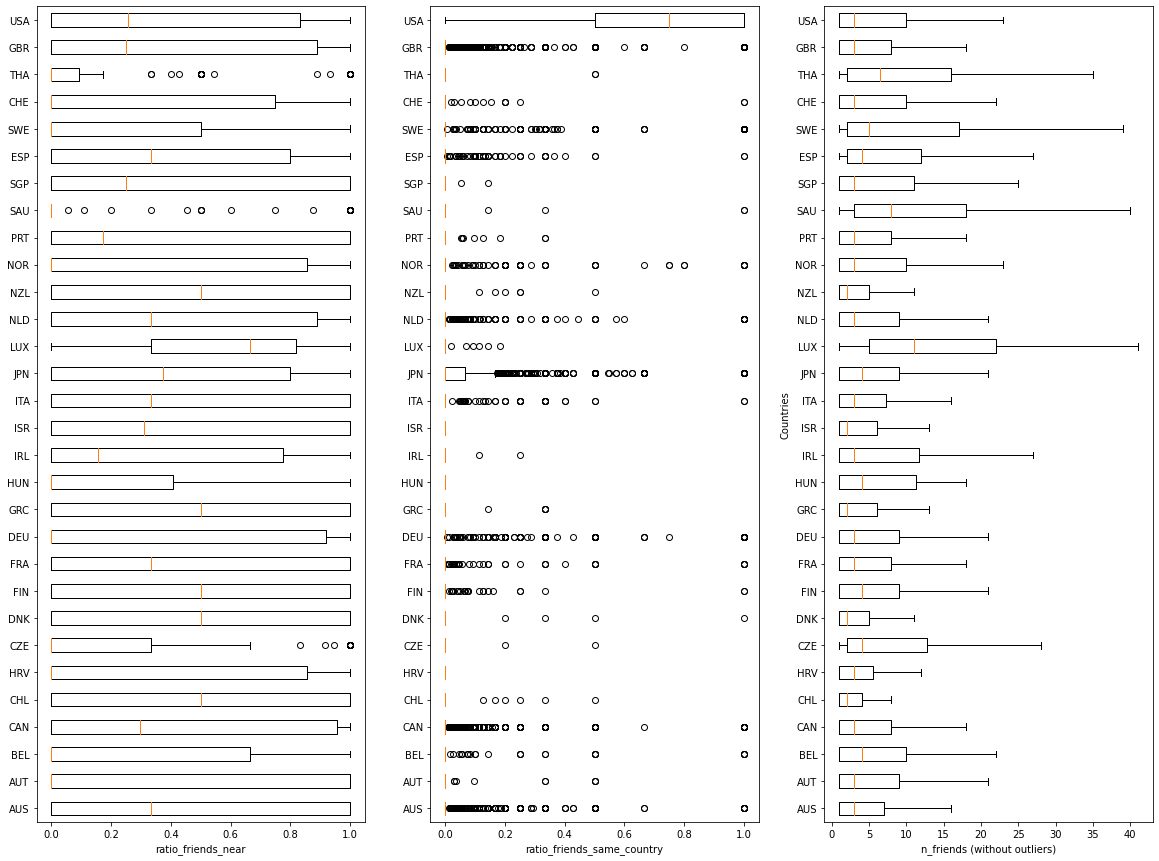

In [52]:
temp = users_all
features = ["ratio_friends_near","ratio_friends_same_country", "n_friends"]

fig, axs = plt.subplots(1, 3, figsize =(20,15))

for i, feature in enumerate(features):
    data = []
    for alpha3 in valid_countries_alpha3:
        users = temp[temp.alpha3 == alpha3]
        data.append(users[feature])
    if i == 2:
        #Impossible to see plots with outliers
        axs[i].boxplot(data,vert=False,showfliers=False)
        axs[i].set_xlabel(feature+" (without outliers)")
    else:
        axs[i].boxplot(data,vert=False,showfliers=True)
        axs[i].set_xlabel(feature)
    axs[i].set_yticks(np.arange(1,len(valid_countries_alpha3)+1))
    axs[i].set_yticklabels(valid_countries_alpha3)
    plt.ylabel("Countries")
plt.show()

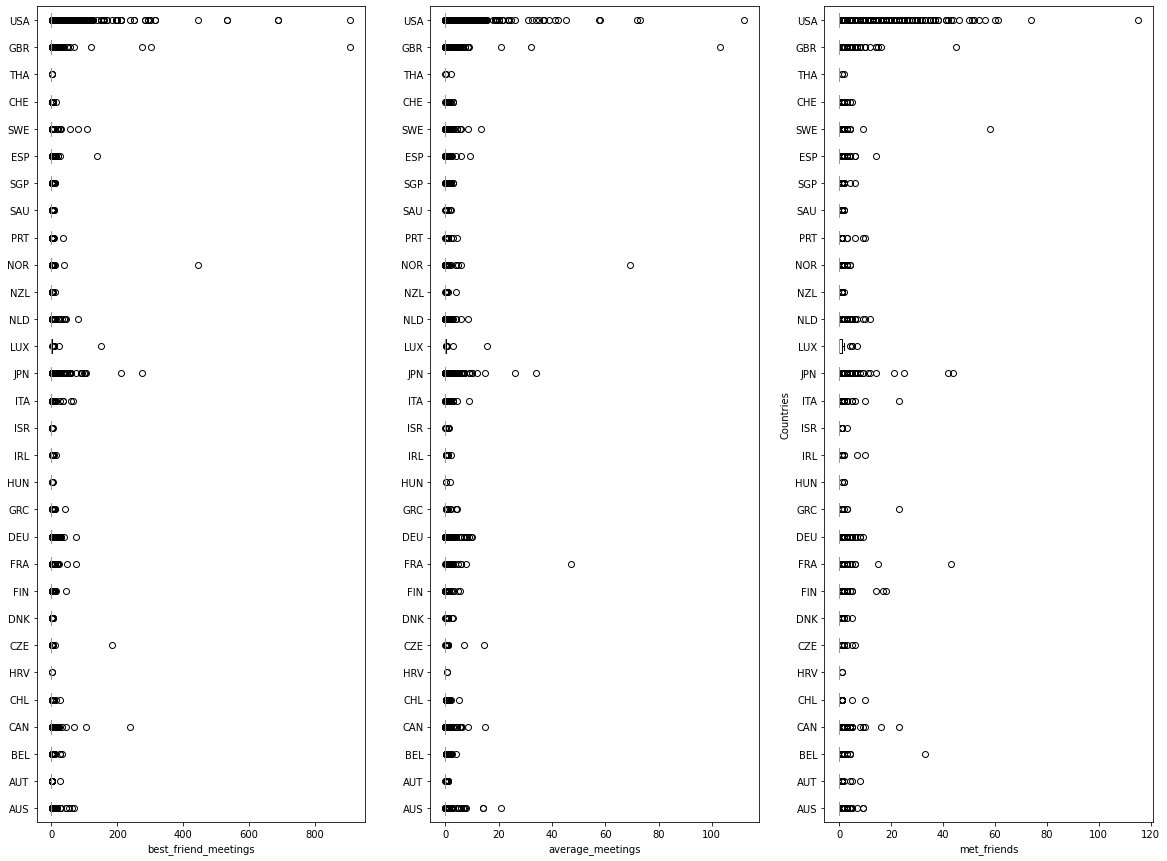

In [53]:
temp = users_all
features = ["best_friend_meetings","average_meetings","met_friends"]

fig, axs = plt.subplots(1, 3, figsize =(20,15))

for i, feature in enumerate(features):
    data = []
    for alpha3 in valid_countries_alpha3:
        users = temp[temp.alpha3 == alpha3]
        data.append(users[feature])
    #Impossible to see plots with outliers
    axs[i].boxplot(data,vert=False,showfliers=True)
    axs[i].set_yticks(np.arange(1,len(valid_countries_alpha3)+1))
    axs[i].set_yticklabels(valid_countries_alpha3)
    axs[i].set_xlabel(feature)
    plt.ylabel("Countries")
plt.show()


#### 3.4.2 Compare the mean of each country

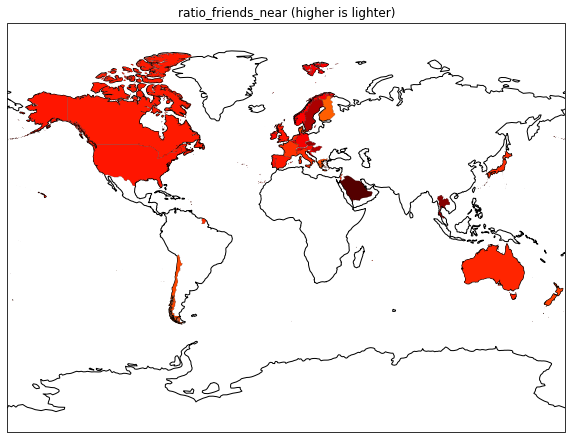

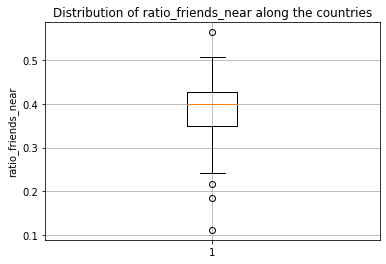

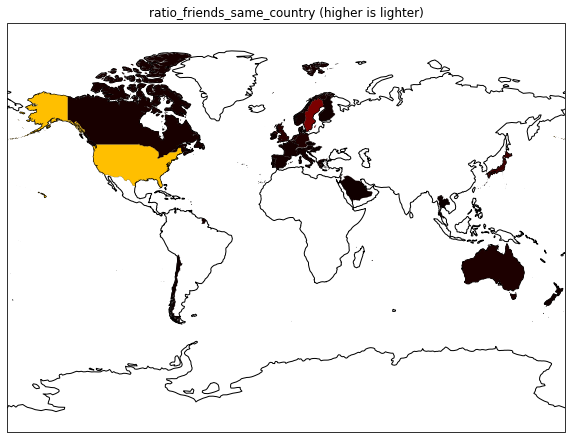

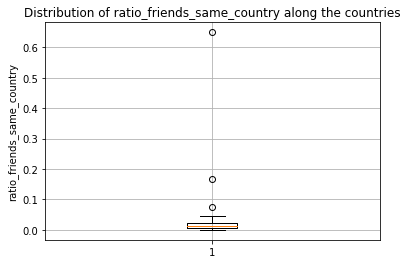

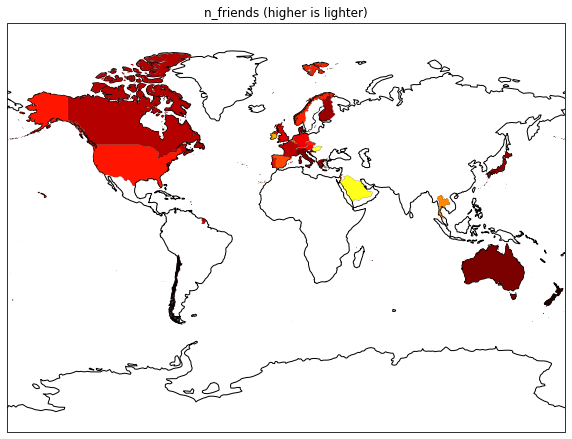

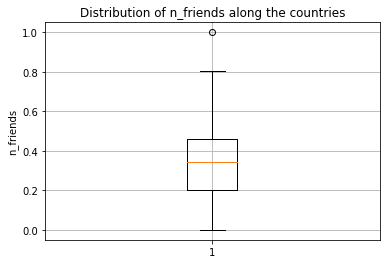

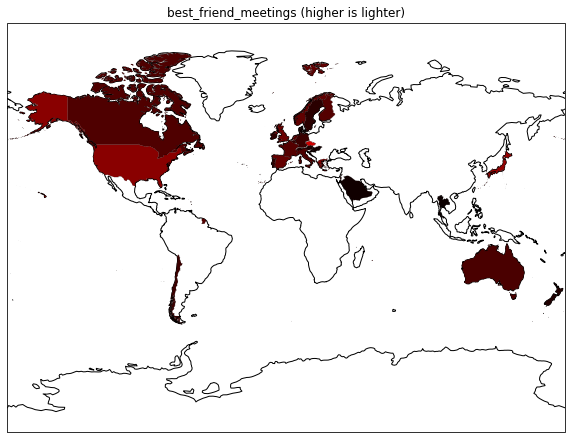

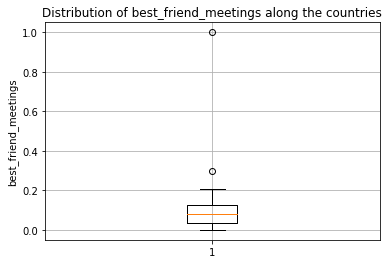

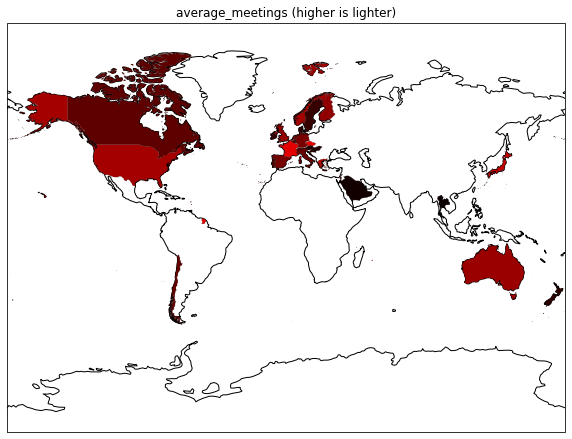

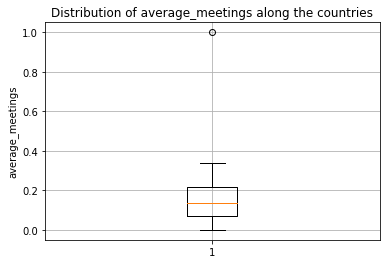

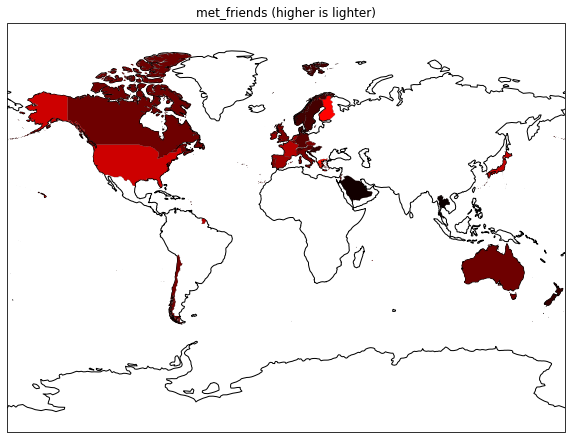

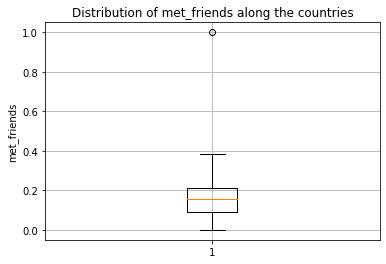

In [54]:
#Min max the value to be printable
temp = countries_friendships_0_1.copy()

features = ["ratio_friends_near","ratio_friends_same_country", "n_friends","best_friend_meetings","average_meetings","met_friends"]

for feature in features:
    #Create the world for the plot
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.Miller())
    ax.add_feature(cfeature.COASTLINE)

    #Plot all countries
    for i in range(0, temp.shape[0]) :
        color = cm.hot(temp.iloc[i][feature])
        area(ax, temp.iloc[i].alpha3, color)

    plt.title(feature+" (higher is lighter)")
    plt.show()
    
    plt.grid()
    plt.boxplot(temp[feature])
    plt.ylabel(feature)
    plt.title("Distribution of "+feature+" along the countries")
    plt.show()

### 3.5 Cluster the friendship informations

In [55]:
#Save id of countries
f_countries_alpha3 =  countries_friendships_std.alpha3

#Remove useless information
countries_friendships = countries_friendships_std.drop(columns = ["alpha3"])

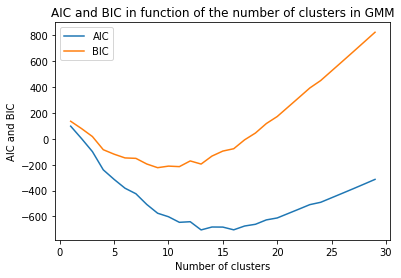

In [56]:
#Initialize the variables
all_aic = []
all_bic = []
NB_MAX_CENTROIDS = countries_friendships.shape[0]

#Evaluate the root mean square (RMS) with different values of k
for nb_centroids in range(1, NB_MAX_CENTROIDS):
    gmm = GaussianMixture(n_components=nb_centroids, n_init = 50, init_params = "kmeans").fit(countries_friendships)
    all_aic.append(gmm.aic(countries_friendships))
    all_bic.append(gmm.bic(countries_friendships))
    
    
#Plot the result
plt.plot(np.arange(1,NB_MAX_CENTROIDS), all_aic, label = "AIC")
plt.plot(np.arange(1,NB_MAX_CENTROIDS), all_bic, label = "BIC")
plt.title("AIC and BIC in function of the number of clusters in GMM")
plt.xlabel("Number of clusters")
plt.ylabel("AIC and BIC")
plt.legend()

The minimum for both metrics is around 14 clusters. That means that the friendships charachteristics are really different from a country to another and that only of few of them can be related.

In [57]:
#Compute with our best resut
BEST_NB_CLUSTERS = 14
gmm = GaussianMixture(n_components=BEST_NB_CLUSTERS, n_init = 100)
labels = gmm.fit_predict(countries_friendships)
res = pd.DataFrame(index = f_countries_alpha3, data = labels, columns =["labels"])

#Print the countries in each cluster
for lab in np.unique(labels):
    print("Label n°"+str(lab))
    print(res[res.labels == lab].index.values)
    
f_friendships_clusters = res

Label n°0
['GBR' 'NOR']
Label n°1
['LUX']
Label n°2
['HUN' 'SAU']
Label n°3
['CHE' 'DNK' 'HRV' 'ISR']
Label n°4
['BEL' 'IRL']
Label n°5
['FIN' 'GRC']
Label n°6
['AUS' 'CAN' 'ITA']
Label n°7
['FRA' 'JPN']
Label n°8
['CZE']
Label n°9
['CHL' 'NZL']
Label n°10
['SWE']
Label n°11
['ESP' 'SGP' 'USA']
Label n°12
['THA']
Label n°13
['AUT' 'DEU' 'NLD' 'PRT']


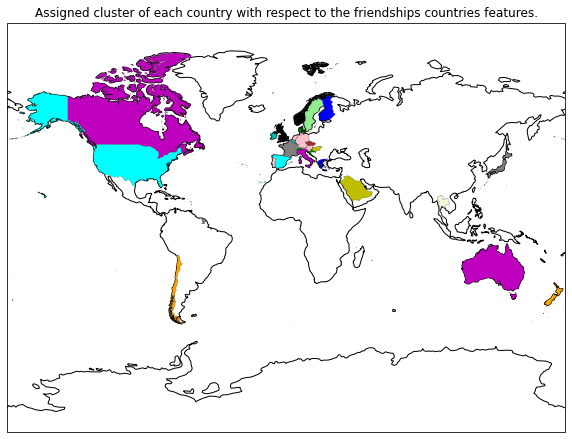

In [58]:
#Create the world for the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

#Extract the clusters
clusters = np.unique(labels)
nb_cluster = np.max(clusters)

#Plot
if(nb_cluster > NB_MAX_GRP): #Some clusters cannot be plotted
    print("COLORS ARE REPEATING")
else:
    for i in range(0, len(labels)) :
        label = labels[i]
        color = color_names[label]
        area(ax, f_countries_alpha3.iloc[i], color)

    plt.title("Assigned cluster of each country with respect to the friendships countries features.")

### 3.6 Verify the statistical difference
Only on the valid countries

#### 3.5.1 Anova test 
Standard ANOVA takes as null hypothesis that all the groups distribution are the same. We assume normal distribution and independence.

In [59]:
features = ["ratio_friends_near","ratio_friends_same_country","n_friends","best_friend_meetings","average_meetings","met_friends"]

temp = users_all.copy()
temp.alpha3 = temp.alpha3.astype(str)
temp = temp[temp['alpha3'].isin(valid_countries_alpha3)]


for feature in features:
    print("\nFeature: "+feature+":")
    res = stat()
    res.anova_stat(df=temp, res_var=feature, anova_model=feature+' ~ C(alpha3)')
    print(res.anova_summary)


Feature: ratio_friends_near:
                df        sum_sq   mean_sq          F        PR(>F)
C(alpha3)     29.0     95.681117  3.299349  19.378535  1.616020e-99
Residual   58796.0  10010.484025  0.170258        NaN           NaN

Feature: ratio_friends_same_country:
                df       sum_sq     mean_sq            F  PR(>F)
C(alpha3)     29.0  4789.031979  165.139034  1553.527854     0.0
Residual   58796.0  6249.977820    0.106299          NaN     NaN

Feature: n_friends:
                df        sum_sq       mean_sq         F        PR(>F)
C(alpha3)     29.0  3.962236e+05  13662.884190  4.211838  2.213654e-13
Residual   58796.0  1.907298e+08   3243.924725       NaN           NaN

Feature: best_friend_meetings:
                df        sum_sq     mean_sq         F    PR(>F)
C(alpha3)     29.0  5.295693e+03  182.610105  1.540149  0.031756
Residual   58796.0  6.971238e+06  118.566539       NaN       NaN

Feature: average_meetings:
                df        sum_sq   mean_sq  

Not really normal

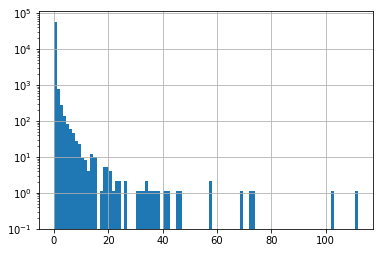

In [60]:
temp = users_all.copy()
temp.alpha3 = temp.alpha3.astype(str)
temp = temp[temp['alpha3'].isin(valid_countries_alpha3)]


series = temp.average_meetings
fig, ax = plt.subplots()
series.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')

#### 3.5.2 Kruskal-Wallis test
The normal distribution is maybe a too strong assumption for our data, so we do the same but with the Kruskal-Wallis test that assume less than ANVOVA. In this case the null hypothesis is that the median is the same for all.

In [61]:
features = ["ratio_friends_near","ratio_friends_same_country","n_friends","best_friend_meetings","average_meetings","met_friends"]

temp_dataset = users_all.copy()
temp_dataset.alpha3 = temp_dataset.alpha3.astype(str)
temp = temp[temp['alpha3'].isin(valid_countries_alpha3)]

for feature in features:    
    print("\nFeature: "+feature+":")
    temp = []
    alpha3s = temp_dataset.alpha3.unique()
    for alpha3 in alpha3s:
        temp.append(temp_dataset[temp_dataset.alpha3 == alpha3][feature])
    print(stats.kruskal(temp[0], temp[1],temp[2],temp[3],temp[4],temp[5],temp[6],temp[7],temp[8],temp[9],temp[10],temp[11],temp[12],temp[13],temp[14],temp[15],temp[16],temp[17],temp[18],temp[19],temp[20],temp[21],temp[22],temp[23],temp[24],temp[25],temp[26],temp[27]))


Feature: ratio_friends_near:
KruskalResult(statistic=453.68839296208057, pvalue=5.257488320339709e-79)

Feature: ratio_friends_same_country:
KruskalResult(statistic=22521.655950496566, pvalue=0.0)

Feature: n_friends:
KruskalResult(statistic=360.71849645939204, pvalue=4.68352795222956e-60)

Feature: best_friend_meetings:
KruskalResult(statistic=201.03356387673205, pvalue=1.5774479726629102e-28)

Feature: average_meetings:
KruskalResult(statistic=189.85020812270136, pvalue=2.085573345889291e-26)

Feature: met_friends:
KruskalResult(statistic=201.5356027935455, pvalue=1.2656947239806088e-28)


Once more the features seems to be statistically different. And that maybe the last conclusion of ANOVA statitics was uncorrect due to the wrong hypotheses.

## 4. Analyze the data

### 4.0 Preprocess

Some of the features have an space that cannot be interpreted by the function because they have spaces in their names. A dictionary is created and applied to avoid this error:

In [62]:
countries_reg = countries_all_features.copy()

In [63]:
friendship_features_names = ["ratio_friends_near","ratio_friends_same_country","n_friends", "best_friend_meetings","average_meetings","met_friends"]

In [64]:
Features = ['Population_growth_rate','Urban_population_growth_rate','Population_density', 'Coastline', 'GPD_growth_rate']
for feature in Features:
    countries_reg[feature] = countries_reg[feature].astype(float)

### 4.1 Correlation matrix and pairplot

In [65]:
corr = countries_reg.corr()
corr = corr[friendship_features_names]
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,ratio_friends_near,ratio_friends_same_country,n_friends,best_friend_meetings,average_meetings,met_friends
best_friend_meetings,0.40,0.08,0.26,1.00,0.97,0.92
average_meetings,0.48,0.07,0.14,0.97,1.00,0.92
met_friends,0.60,0.10,0.16,0.92,0.92,1.00
n_friends,-0.54,0.11,1.00,0.26,0.14,0.16
ratio_friends_same_country,-0.01,1.00,0.11,0.08,0.07,0.10
ratio_friends_near,1.00,-0.01,-0.54,0.40,0.48,0.60
happiness_score,0.21,0.09,0.03,0.12,0.11,0.08
social_support,0.13,0.02,0.03,-0.07,-0.05,-0.11
freedom_of_choices,-0.04,0.04,0.19,0.04,0.03,-0.04
generosity,0.06,0.19,-0.01,-0.11,-0.15,-0.18


Interesting points: (only consider > 0.5 correlation)

Correlations btw friendships charachs:
1. nb friends <-> total nb friends
2. best friend meeting  <->  total meeting  <-> met friends
3. met friends <-> total nb friends

Correlations with ratio_friends_near:
1. happiness_score (invers effect ? people are happy bcs friends are near)
2. perception_of_corruption (?)
3. GDP_per_capita (more urbanized)

Correlations with ratio_friends_same_country:
1. International_migrant_stock (people are not in the country)
2. Heath_total_expenditure (maybe influence migration)
3. Individuals_using_the_Internet (?)
4. Forested_area (? few friends near so more okay to find worlwide friends)

Correlations with total_nb_friends:
1. International_migrant_stock (?)
2. Forested_area (?)

Coorelations with all qualitatives -> DO NOT HAVE BIGGER THAN 50 -> quality does not change

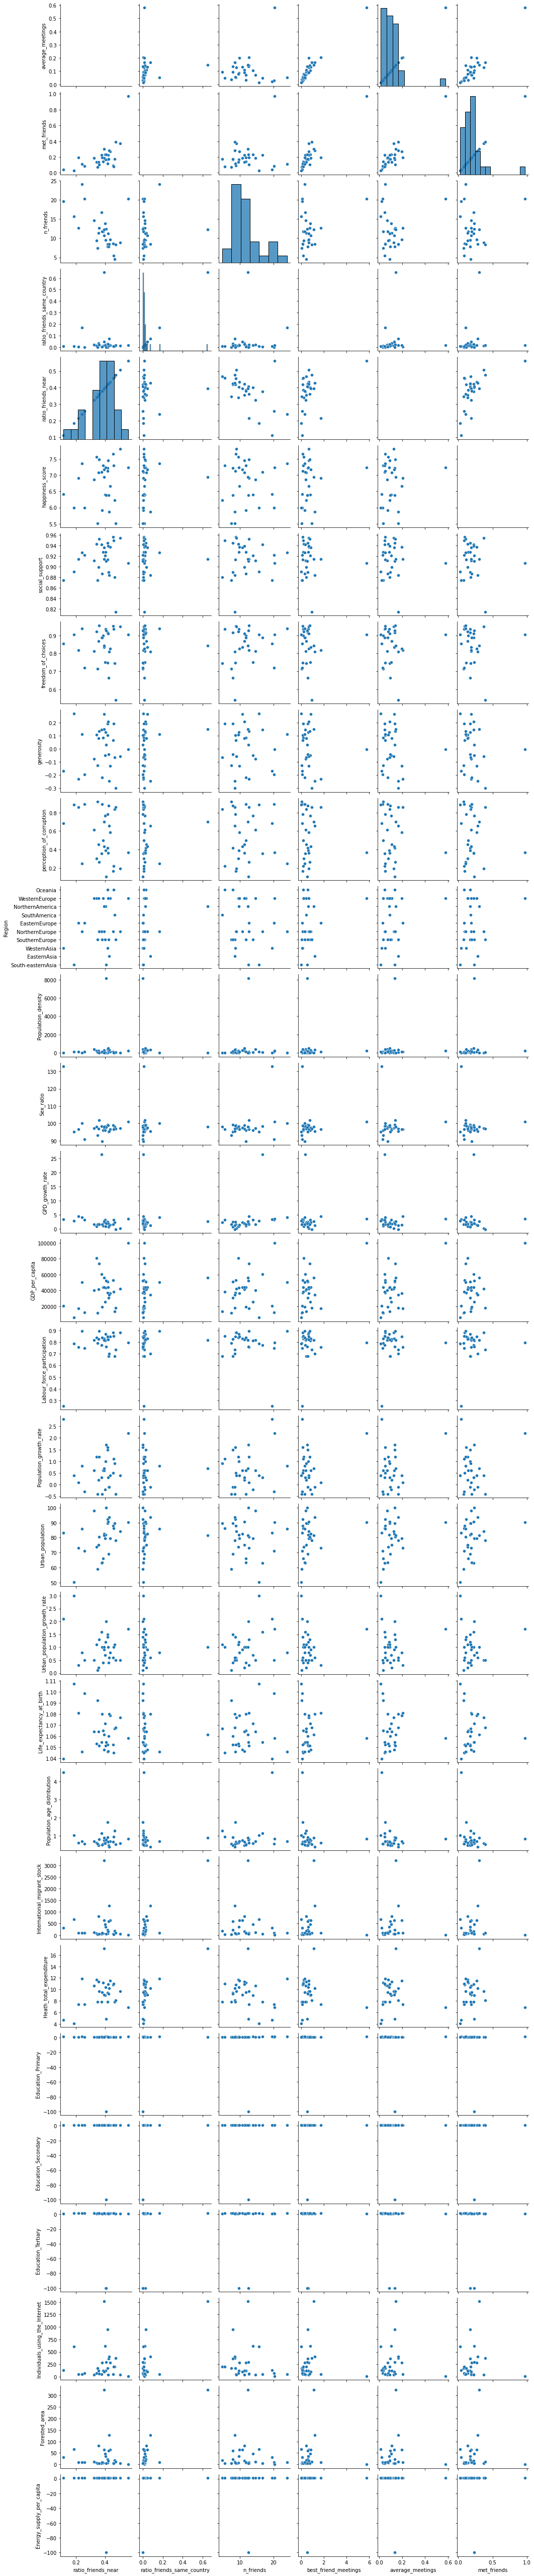

In [66]:
sns.pairplot(countries_reg,x_vars=friendship_features_names,
            y_vars = countries_reg.columns[2:-1])

Most of the plots seem to be random, although some seem to have a "tendency" like influence of near friends on happiness.

## 4.2 PCA

### 4.2.1 PCA on all

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [30] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


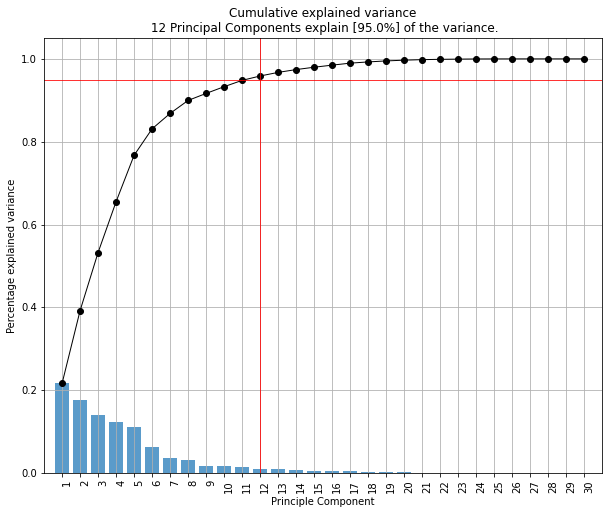

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 12 Principal Components explain [95.0%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [67]:
# Initialize
model = pca()
df_temp = countries_all_features_std.drop(columns = ["Region","alpha3"])

# Fit transform
out = model.fit_transform(df_temp)

model.plot()

Looking at the cumulative variance we know that the 12th first PCA are significative. For each PC we will know compute what was the original variable that had the more influence.

In [68]:
# Print the top features. The results show that f1 is best, followed by f2 etc
print(out['topfeat'][:12])

      PC                      feature   loading  type
0    PC1     perception_of_corruption -0.315127  best
1    PC2      Heath_total_expenditure -0.327806  best
2    PC3  Population_age_distribution  0.385489  best
3    PC4  International_migrant_stock  0.423493  best
4    PC5         best_friend_meetings  0.468001  best
5    PC6                    n_friends  0.410102  best
6    PC7                    n_friends  0.508573  best
7    PC8              GPD_growth_rate  0.785323  best
8    PC9           Education_Tertiary -0.627203  best
9   PC10           Education_Tertiary -0.567542  best
10  PC11                    Coastline  0.448636  best
11  PC12             Urban_population -0.445711  best


Interestingly we see that some friendship features appears. Especially ratio_friends_same_country  and average_meetings  which means they are a way (maybe indirect) to discriminate countries.

### 4.2.2 PCA to reduce countries features

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [24] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


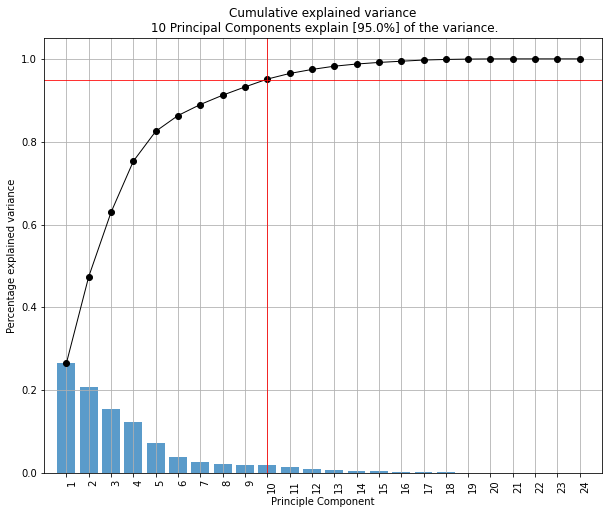

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 10 Principal Components explain [95.0%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [69]:
# Initialize
model = pca()
    
TO_REMOVE =  ["Region","alpha3"]+friendship_features_names
df_temp = countries_all_features_std.drop(columns =TO_REMOVE)
# Fit transform
out = model.fit_transform(df_temp)

model.plot()

Looking at the cumulative variance we know that the 10th first PCA are significative. For each PC we will know compute what was the original variable that had the more influence.

In [70]:
# Print the top features. The results show that f1 is best, followed by f2 etc
print(out['topfeat'][:10])

     PC                      feature   loading  type
0   PC1     perception_of_corruption -0.307482  best
1   PC2              happiness_score -0.375352  best
2   PC3  Population_age_distribution  0.480487  best
3   PC4  International_migrant_stock  0.537406  best
4   PC5             Urban_population -0.487686  best
5   PC6              GPD_growth_rate  0.792389  best
6   PC7           freedom_of_choices -0.454188  best
7   PC8           Education_Tertiary -0.526180  best
8   PC9           Education_Tertiary -0.637317  best
9  PC10               GDP_per_capita  0.492673  best


Usually, with PCA we take the PC as vector for the rest of the code. However here we need to keep a sense of meaning to our variables, so we will jsut extract the features that were the most important for each PC.

In [71]:
reduced_countries_features = out['topfeat']["feature"][:10].values

### 4.3 Regression on all
Need to see to which extent our previous conclusion are verified

#### 4.3.1 Happiness influenced by friendship charachteristics

In [72]:
mod = smf.ols(formula = 'happiness_score ~ ratio_friends_near + ratio_friends_same_country + n_friends', data = countries_all_features_std)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        happiness_score   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.7185
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.550
Time:                        21:22:12   Log-Likelihood:                -41.373
No. Observations:                  30   AIC:                             90.75
Df Residuals:                      26   BIC:                             96.35
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

### 4.3.2 Friends near depending on all country features

In [73]:
FEATURES_REG = " ~ happiness_score + \
 social_support + freedom_of_choices + generosity + perception_of_corruption + \
 Population_density + Sex_ratio + GPD_growth_rate + GDP_per_capita + Labour_force_participation + \
 Population_growth_rate + Urban_population + Urban_population_growth_rate + Life_expectancy_at_birth + \
 Population_age_distribution + International_migrant_stock + Heath_total_expenditure + Education_Primary + \
 Education_Secondary + Education_Tertiary + Individuals_using_the_Internet + Forested_area + Energy_supply_per_capita + \
 Coastline"

In [74]:
mod = smf.ols(formula="ratio_friends_near"+FEATURES_REG , data=countries_all_features_std)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     ratio_friends_near   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     1.686
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.295
Time:                        21:22:12   Log-Likelihood:                -9.4550
No. Observations:                  30   AIC:                             68.91
Df Residuals:                       5   BIC:                             103.9
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

We can say nothing about the results due to the p-values.

### 4.3.3 Friends in the same country depending on all country features

In [75]:
mod = smf.ols(formula='ratio_friends_same_country'+FEATURES_REG, data=countries_all_features_std)
res = mod.fit()
print(res.summary())

                                OLS Regression Results                                
Dep. Variable:     ratio_friends_same_country   R-squared:                       0.979
Model:                                    OLS   Adj. R-squared:                  0.879
Method:                         Least Squares   F-statistic:                     9.749
Date:                        Thu, 17 Dec 2020   Prob (F-statistic):            0.00935
Time:                                21:22:12   Log-Likelihood:                 15.436
No. Observations:                          30   AIC:                             19.13
Df Residuals:                               5   BIC:                             54.16
Df Model:                                  24                                         
Covariance Type:                    nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

Forested area, population density, migrant stock and corruption seem to have an influence. With less certitude: appiness, labour force participation urban population and energy supply.

### 4.3.3 Total number of friends depending on all country features

In [76]:
mod = smf.ols(formula='n_friends'+FEATURES_REG, data=countries_all_features_std)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              n_friends   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     1.590
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.321
Time:                        21:22:12   Log-Likelihood:                -10.233
No. Observations:                  30   AIC:                             70.47
Df Residuals:                       5   BIC:                             105.5
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

With low certitude: social support, generosity, corruption and sec ratio may have an influence.

### 4.3.4 Number of best friends meeting depending on all country features

In [77]:
mod = smf.ols(formula='best_friend_meetings'+FEATURES_REG, data=countries_all_features_std)
res = mod.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     best_friend_meetings   R-squared:                       0.920
Model:                              OLS   Adj. R-squared:                  0.538
Method:                   Least Squares   F-statistic:                     2.405
Date:                  Thu, 17 Dec 2020   Prob (F-statistic):              0.167
Time:                          21:22:12   Log-Likelihood:                -4.6277
No. Observations:                    30   AIC:                             59.26
Df Residuals:                         5   BIC:                             94.29
Df Model:                            24                                         
Covariance Type:              nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

Nothing can be said, just that maybe population density has an influence.

### 4.3.5 Average meetings depending on all country features

In [78]:
mod = smf.ols(formula='average_meetings'+FEATURES_REG, data=countries_all_features_std)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       average_meetings   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     4.337
Date:                Thu, 17 Dec 2020   Prob (F-statistic):             0.0546
Time:                        21:22:12   Log-Likelihood:                 3.6715
No. Observations:                  30   AIC:                             42.66
Df Residuals:                       5   BIC:                             77.69
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Nothing can be said, just maybe that age density and forested area may influence

### 4.3.6 Total number of meetings with friends depending on all country features

In [79]:
mod = smf.ols(formula='met_friends'+FEATURES_REG, data=countries_all_features_std)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            met_friends   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     1.940
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.238
Time:                        21:22:13   Log-Likelihood:                -7.5666
No. Observations:                  30   AIC:                             65.13
Df Residuals:                       5   BIC:                             100.2
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Nothing can be said, just that maybe freedom of choices, generosity, population density and coastline may influence.

### 4.3.7 Regression conclusion
Few major elements -> maybe same everywhere. Non-lin regression doesn't seem necessary because the pairplot seem to show that it is random.

## 4.4 Regression on reduced dataset

### 4.4.1 Friends near depending on all country features

In [80]:
to_test = "ratio_friends_near"
txt = to_test+" ~ "
for i, feature in enumerate(reduced_countries_features):
    if(i != 0):
        txt+=" + "
    txt+=feature

print("Formula: "+txt)
    
mod = smf.ols(formula=txt, data=countries_all_features_std)
res = mod.fit()
print(res.summary())

Formula: ratio_friends_near ~ perception_of_corruption + happiness_score + Population_age_distribution + International_migrant_stock + Urban_population + GPD_growth_rate + freedom_of_choices + Education_Tertiary + Education_Tertiary + GDP_per_capita
                            OLS Regression Results                            
Dep. Variable:     ratio_friends_near   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     2.244
Date:                Thu, 17 Dec 2020   Prob (F-statistic):             0.0634
Time:                        21:22:13   Log-Likelihood:                -32.096
No. Observations:                  30   AIC:                             84.19
Df Residuals:                      20   BIC:                             98.20
Df Model:                           9                                         
Covariance Type:            nonrobust  

GDP influences the nb of near friends. With less certitude does the forested areas.

### 4.4.2 Friends in the same country depending on all country features

In [81]:
to_test = "ratio_friends_same_country"
txt = to_test+" ~ "
for i, feature in enumerate(reduced_countries_features):
    if(i != 0):
        txt+=" + "
    txt+=feature

print("Formula: "+txt)
    
mod = smf.ols(formula=txt, data=countries_all_features_std)
res = mod.fit()
print(res.summary())

Formula: ratio_friends_same_country ~ perception_of_corruption + happiness_score + Population_age_distribution + International_migrant_stock + Urban_population + GPD_growth_rate + freedom_of_choices + Education_Tertiary + Education_Tertiary + GDP_per_capita
                                OLS Regression Results                                
Dep. Variable:     ratio_friends_same_country   R-squared:                       0.809
Model:                                    OLS   Adj. R-squared:                  0.723
Method:                         Least Squares   F-statistic:                     9.427
Date:                        Thu, 17 Dec 2020   Prob (F-statistic):           1.80e-05
Time:                                21:22:13   Log-Likelihood:                -17.718
No. Observations:                          30   AIC:                             55.44
Df Residuals:                              20   BIC:                             69.45
Df Model:                                   9 

Now, only forested areas seem to have an influence on the friends in the same country.

### 4.4.3 Total number of friends depending on all country features

In [82]:
to_test = "n_friends"
txt = to_test+" ~ "
for i, feature in enumerate(reduced_countries_features):
    if(i != 0):
        txt+=" + "
    txt+=feature

print("Formula: "+txt)
    
mod = smf.ols(formula=txt, data=countries_all_features_std)
res = mod.fit()
print(res.summary())

Formula: n_friends ~ perception_of_corruption + happiness_score + Population_age_distribution + International_migrant_stock + Urban_population + GPD_growth_rate + freedom_of_choices + Education_Tertiary + Education_Tertiary + GDP_per_capita
                            OLS Regression Results                            
Dep. Variable:              n_friends   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                 -0.062
Method:                 Least Squares   F-statistic:                    0.8116
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.612
Time:                        21:22:13   Log-Likelihood:                -37.899
No. Observations:                  30   AIC:                             95.80
Df Residuals:                      20   BIC:                             109.8
Df Model:                           9                                         
Covariance Type:            nonrobust           

Forested areas and gdp per capita

### 4.4.4 Number of best friends meeting depending on all country features

In [83]:
to_test = "best_friend_meetings"
txt = to_test+" ~ "
for i, feature in enumerate(reduced_countries_features):
    if(i != 0):
        txt+=" + "
    txt+=feature

print("Formula: "+txt)
    
mod = smf.ols(formula=txt, data=countries_all_features_std)
res = mod.fit()
print(res.summary())

Formula: best_friend_meetings ~ perception_of_corruption + happiness_score + Population_age_distribution + International_migrant_stock + Urban_population + GPD_growth_rate + freedom_of_choices + Education_Tertiary + Education_Tertiary + GDP_per_capita
                             OLS Regression Results                             
Dep. Variable:     best_friend_meetings   R-squared:                       0.513
Model:                              OLS   Adj. R-squared:                  0.293
Method:                   Least Squares   F-statistic:                     2.338
Date:                  Thu, 17 Dec 2020   Prob (F-statistic):             0.0546
Time:                          21:22:13   Log-Likelihood:                -31.786
No. Observations:                    30   AIC:                             83.57
Df Residuals:                        20   BIC:                             97.58
Df Model:                             9                                         
Covariance Type:   

Nothing can be said, just that maybe population density has an influence.

### 4.4.5 Average meetings depending on all country features

In [84]:
to_test = "average_meetings"
txt = to_test+" ~ "
for i, feature in enumerate(reduced_countries_features):
    if(i != 0):
        txt+=" + "
    txt+=feature

print("Formula: "+txt)
    
mod = smf.ols(formula=txt, data=countries_all_features_std)
res = mod.fit()
print(res.summary())

Formula: average_meetings ~ perception_of_corruption + happiness_score + Population_age_distribution + International_migrant_stock + Urban_population + GPD_growth_rate + freedom_of_choices + Education_Tertiary + Education_Tertiary + GDP_per_capita
                            OLS Regression Results                            
Dep. Variable:       average_meetings   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     2.521
Date:                Thu, 17 Dec 2020   Prob (F-statistic):             0.0408
Time:                        21:22:13   Log-Likelihood:                -31.196
No. Observations:                  30   AIC:                             82.39
Df Residuals:                      20   BIC:                             96.40
Df Model:                           9                                         
Covariance Type:            nonrobust    

GDP, maybe freedom

### 4.4.6 Total number of meetings with friends depending on all country features

In [85]:
to_test = "met_friends"
txt = to_test+" ~ "
for i, feature in enumerate(reduced_countries_features):
    if(i != 0):
        txt+=" + "
    txt+=feature

print("Formula: "+txt)
    
mod = smf.ols(formula=txt, data=countries_all_features_std)
res = mod.fit()
print(res.summary())

Formula: met_friends ~ perception_of_corruption + happiness_score + Population_age_distribution + International_migrant_stock + Urban_population + GPD_growth_rate + freedom_of_choices + Education_Tertiary + Education_Tertiary + GDP_per_capita
                            OLS Regression Results                            
Dep. Variable:            met_friends   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     2.127
Date:                Thu, 17 Dec 2020   Prob (F-statistic):             0.0767
Time:                        21:22:13   Log-Likelihood:                -32.496
No. Observations:                  30   AIC:                             84.99
Df Residuals:                      20   BIC:                             99.00
Df Model:                           9                                         
Covariance Type:            nonrobust         

freedom and gpd

### 4.4.7 Reduced Regression conclusion
Lot of information but some really certaind. Importance of GDP

## 5. Matching
For elements that seemed importants and make sens in the regression do matching to verify that it is right. Maybe use the cluster as a matching condition.